In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import igraph as ig
from collections import defaultdict
import numpy as np
import random



### Building the network from the original data

In [3]:
# Sample dataframe (replace with actual data)
data = pd.DataFrame({
    "Source": ["A", "A", "B", "A", "A", "B"],
    "Target": ["A", "B", "A", "A", "B", "A"],
    "Mediator": ["X", "X", "Y", "Y", "Z", "Z"],
    "Action": ["Positive", "Positive", "Negative", "Positive", "Positive", "Negative"]
})


data = pd.read_csv('../data_processed/filtered_cell_network_filtered_actions.csv')
data = data[['Source','Target','Action','Mediator','Immune_Process']]
data = data.drop_duplicates()
print(len(data))
print(data.to_string())


699
          Source         Target    Action                    Mediator                                                                                                                                                                                                                                 Immune_Process
0              B              B  Activate                        BAFF                                                                                                                                                       [' Class switching', 'Antibody production', 'T independent B activation/IgA production']
1              B              B  Activate                        IL10                                                                                                                                                                                                       ['Class switching', 'Immunosuppression']
2              B              B  Activate                         IL6

Presenting data for each of the cytokines

In [22]:
df_cyts = pd.DataFrame(columns = ['cyt','cyt_len','num_cells_sec','cells_sec','num_cells_rec','cells_rec'])

for cyt, cyt_data in data.groupby('Mediator'):
    row = {'cyt':[cyt],'cyt_len':[len(cyt_data)]}
    row['num_cells_sec'] = [len(cyt_data['Source'].unique())]
    row['num_cells_rec'] = [len(cyt_data['Target'].unique())]
    row['cells_sec'] = [cyt_data['Source'].unique()]
    row['cells_rec'] = [cyt_data['Target'].unique()]
    df_cyts = pd.concat([df_cyts,pd.DataFrame(row)],ignore_index=True)
df_cyts = df_cyts.sort_values(by = 'cyt_len',ascending=False)
print(df_cyts.to_string())
print(len(df_cyts))
print(len(data))
cyts_to_remove = df_cyts['cyt'][:2].values
cyts_to_remove = ['IFNg','TGFb']
print(cyts_to_remove)

                           cyt cyt_len num_cells_sec                                                                    cells_sec num_cells_rec                                                                   cells_rec
57                        TGFb      56             7                             [DC, Eosinophil, IEL, Monocyte, T_reg, Tfh, Th2]             8  [Eosinophil, Macrophage, Neutrophil, T_CD4, T_CD8_memory, T_reg, Th1, Th2]
20                        IFNg      55            11  [IEL, ILC1, ILC3, NK, Neutrophil, T_CD8, T_Cytotoxic, T_gd, Tfh, Th1, Th17]             5                                            [DC, Macrophage, NK, T_reg, Th2]
22                        IL10      54             9                [B, DC, Macrophage, Mast, T_Cytotoxic, T_reg, Th1, Th17, Th2]             6                                     [B, DC, Macrophage, Mast, T_CD4, T_reg]
44                         IL6      49             7                          [B, DC, Eosinophil, Macrophage, Monocyte, 

In [23]:
def create_flattened_graph_from_data(data,flatten_actions = False):
    #this function takes data and returns a graph in which each action is encoded by one arrow (regardless of the number of mediators)
    data = data.copy()
    if flatten_actions:
        action_lam = lambda act: "Positive" if act in ['Activate','Survive','Positive'] else 'Negative'
        data['Action'] = data['Action'].apply(action_lam)
    data = data[['Source','Target','Action']].drop_duplicates()
    g = ig.Graph(directed=True)
    vertices = set(data["Source"]).union(set(data["Target"]))
    g.add_vertices(list(vertices))
    
    edge_list = [(row["Source"], row["Target"], row["Action"]) for _, row in data.iterrows()]
    
    g.add_edges([(u, v) for u, v, _ in edge_list])
    for idx, (_, _, action) in enumerate(edge_list):
        g.es[idx]["Action"] = action
    return g

def create_flattened_graph_from_data_weights (data):
    # this function returns a graph in which there is only one arrow between each pair of nodes. 
    # The actions of the different mediators are encoded in the weights: a positive weight means that there was at least one mediator of a survive or activate action;
    # a negative weight means there was at least one mediator of a kill or inhibit action.

    edges = []
    edge_actions = {}

    for _, row in data.iterrows():
        edges.append((row["Source"], row["Target"]))
        edge_actions[(row["Source"], row["Target"])] = row["Action"]

    edges = list(set(edges))
    weights_positive = []
    weights_negative = []
    dfs = []
    edges_to_keep = []
    weights_negative_to_keep = []
    weights_positive_to_keep = []
    dfs_to_keep = []
    for edge in edges:
        df_edge = data[(data["Source"]==edge[0])&(data["Target"]==edge[1])]
        mask_positive = [df_edge.iloc[i]['Action'] in ['Survive','Activate'] for i in range(len(df_edge))]
        mask_negative = [df_edge.iloc[i]['Action'] in ['Kill','Inhibit'] for i in range(len(df_edge))]
        weights_positive.append(int(len(df_edge[mask_positive])>0))
        weights_negative.append(int(len(df_edge[mask_negative])>0))
        dfs.append(df_edge)
        if int(len(df_edge[mask_positive])>0)+int(len(df_edge[mask_negative])>0)==1: #additional conditioning for pure interactions
            edges_to_keep.append(edge)
            weights_negative_to_keep.append(int(len(df_edge[mask_negative])>0))
            weights_positive_to_keep.append(int(len(df_edge[mask_positive])>0))
            dfs_to_keep.append(df_edge)
    # Step 2: Create the directed graph
    g = ig.Graph(directed=True)
    g.add_vertices(list(set(data["Source"]).union(set(data["Target"]))))
    g.add_edges(edges)
    g.es["weight_positive"] = weights_positive
    g.es["weight_negative"] = weights_negative
    g.es['df'] = dfs

    return g

g = create_flattened_graph_from_data_weights(data)
print(len(g.es))
data_cyt_filtered = data[~data['Mediator'].isin(cyts_to_remove)] #remove common cytokines
g_filtered = create_flattened_graph_from_data_weights(data_cyt_filtered)
print(len(g_filtered.es))


324
265


In [24]:
def count_excitable_motif (g):
    motif = ig.Graph(directed=True)
    motif.add_vertices(2)  # Two unique nodes: A, B
    motif.add_edges([(0, 0), (0, 1), (1, 0)])  # A → A, A → B, B → A
    # Step 4: Find motifs using LAD (supports self-loops)
    matches = g.get_subisomorphisms_lad(motif)
    filtered_count = 0
    # Step 5: Count motifs that match the action pattern
    filtered_count = 0
    for match in matches:
        a, b = g.vs[match[0]]["name"], g.vs[match[1]]["name"]
        # Ensure the edges exist and fetch their actions
        if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):
            edge_1_id = g.get_eid(a, a)
            edge_2_id = g.get_eid(a, b)
            edge_3_id = g.get_eid(b, a)

            edge_1_weight_pos = int(g.es[edge_1_id]["weight_positive"]!=0)
            edge_2_weight_pos = int(g.es[edge_2_id]["weight_positive"]!=0)
            edge_3_weight_neg = int(g.es[edge_3_id]["weight_negative"]!=0)
            add = edge_1_weight_pos*edge_2_weight_pos*edge_3_weight_neg
            filtered_count += add 
    return filtered_count


def find_excitable_motif (g,verbose = False):
    motif = ig.Graph(directed=True)
    motif.add_vertices(2)  # Two unique nodes: A, B
    motif.add_edges([(0, 0), (0, 1), (1, 0)])  # A → A, A → B, B → A
    # Step 4: Find motifs using LAD (supports self-loops)
    matches = g.get_subisomorphisms_lad(motif)
    # Step 5: Count motifs that match the action pattern
    filtered_count = 0
    edges = []
    dfs = {}
    for match in matches:
        a, b = g.vs[match[0]]["name"], g.vs[match[1]]["name"]
        if verbose:
            print(a,b)
        # Ensure the edges exist and fetch their actions
        if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):
            edge_1_id = g.get_eid(a, a)
            edge_2_id = g.get_eid(a, b)
            edge_3_id = g.get_eid(b, a)
            if verbose:
                print(g.es[edge_1_id]['df'][['Source','Target','Action','Mediator']])
                print(g.es[edge_2_id]['df'][['Source','Target','Action','Mediator']])
                print(g.es[edge_3_id]['df'][['Source','Target','Action','Mediator']])
            
            edge_1_weight_pos = int(g.es[edge_1_id]["weight_positive"]!=0)
            edge_2_weight_pos = int(g.es[edge_2_id]["weight_positive"]!=0)
            edge_3_weight_neg = int(g.es[edge_3_id]["weight_negative"]!=0)
            if verbose: print(edge_1_weight_pos,edge_2_weight_pos,edge_3_weight_neg)
            add = edge_1_weight_pos*edge_2_weight_pos*edge_3_weight_neg
            filtered_count += add 
            if add!=0:
                edges.append((a,b))
                dfs[(a,b)] = (g.es[edge_1_id]['df'],g.es[edge_2_id]['df'],g.es[edge_3_id]['df'])
    #print("Number of matching motifs:", filtered_count)
    return filtered_count,edges,dfs

def find_excitable_motif_mod (g):
    motif = ig.Graph(directed=True)
    motif.add_vertices(2)  # Two unique nodes: A, B
    motif.add_edges([(0, 0), (0, 1), (1, 0), (1,1)])  # A → A, A → B, B → A
    # Step 4: Find motifs using LAD (supports self-loops)
    matches = g.get_subisomorphisms_lad(motif)
    # Step 5: Count motifs that match the action pattern
    filtered_count = 0
    edges = []
    dfs = {}
    for match in matches:
        a, b = g.vs[match[0]]["name"], g.vs[match[1]]["name"]
        # Ensure the edges exist and fetch their actions
        if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):
            edge_1_id = g.get_eid(a, a)
            edge_2_id = g.get_eid(a, b)
            edge_3_id = g.get_eid(b, a)
            edge_4_id = g.get_eid(b, b)

            edge_1_weight_pos = int(g.es[edge_1_id]["weight_positive"]!=0)
            edge_2_weight_pos = int(g.es[edge_2_id]["weight_positive"]!=0)
            edge_3_weight_neg = int(g.es[edge_3_id]["weight_negative"]!=0)
            edge_4_weight_neg = int(g.es[edge_4_id]["weight_negative"]!=0)

            add = edge_1_weight_pos*edge_2_weight_pos*edge_3_weight_neg*edge_4_weight_neg
            filtered_count += add 
            if add!=0:
                edges.append((a,b))
                dfs[(a,b)] = (g.es[edge_1_id]['df'],g.es[edge_2_id]['df'],g.es[edge_3_id]['df'],g.es[edge_4_id]['df'])
    #print("Number of matching motifs:", filtered_count)
    return filtered_count,edges,dfs

def count_excitable_motif_b (g):
    motif = ig.Graph(directed=True)
    motif.add_vertices(2)  # Two unique nodes: A, B
    motif.add_edges([(0, 0), (0, 1), (1, 0)])  # A → A, A → B, B → A
    # Step 4: Find motifs using LAD (supports self-loops)
    matches = g.get_subisomorphisms_lad(motif)
    filtered_count = 0
    # Step 5: Count motifs that match the action pattern
    filtered_count = 0
    for match in matches:
        a, b = g.vs[match[0]]["name"], g.vs[match[1]]["name"]
        
        # Ensure the edges exist and fetch their actions
        if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):
            edge_1_id = g.get_eid(a, a)
            edge_2_id = g.get_eid(a, b)
            edge_3_id = g.get_eid(b, a)

            edge_1_weight_pos = g.es[edge_1_id]["weight_positive"]
            edge_2_weight_pos = g.es[edge_2_id]["weight_negative"]
            edge_3_weight_neg = g.es[edge_3_id]["weight_positive"]

            filtered_count += 1*edge_1_weight_pos*edge_2_weight_pos*edge_3_weight_neg

    #print("Number of matching motifs:", filtered_count)
    return filtered_count
def find_excitable_motif_b (g):
    motif = ig.Graph(directed=True)
    motif.add_vertices(2)  # Two unique nodes: A, B
    motif.add_edges([(0, 0), (0, 1), (1, 0)])  # A → A, A → B, B → A
    # Step 4: Find motifs using LAD (supports self-loops)
    matches = g.get_subisomorphisms_lad(motif)
    # Step 5: Count motifs that match the action pattern
    filtered_count = 0
    edges = []
    dfs = {}
    for match in matches:
        a, b = g.vs[match[0]]["name"], g.vs[match[1]]["name"]
        
        # Ensure the edges exist and fetch their actions
        if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):
            edge_1_id = g.get_eid(a, a)
            edge_2_id = g.get_eid(a, b)
            edge_3_id = g.get_eid(b, a)

            edge_1_weight_pos = int(g.es[edge_1_id]["weight_positive"]!=0)
            edge_2_weight_neg = int(g.es[edge_2_id]["weight_negative"]!=0)
            edge_3_weight_pos = int(g.es[edge_3_id]["weight_positive"]!=0)
            add = edge_1_weight_pos*edge_2_weight_neg*edge_3_weight_pos
            filtered_count += add 
            if add!=0:
                edges.append((a,b))
                dfs[(a,b)] = (g.es[edge_1_id]['df'],g.es[edge_2_id]['df'],g.es[edge_3_id]['df'])
    #print("Number of matching motifs:", filtered_count)
    return filtered_count,edges,dfs


printing all the excitable motifs 

In [27]:
filtered_count,edges,dfs = find_excitable_motif(g)
print(filtered_count)
for couple in dfs.keys():
    print(couple)

31
('T_CD4', 'B')
('T_CD4', 'T_reg')
('Monocyte', 'DC')
('T_reg', 'Eosinophil')
('T_reg', 'B')
('Eosinophil', 'B')
('DC', 'Th1')
('DC', 'Macrophage')
('DC', 'B')
('DC', 'T_reg')
('DC', 'Mast')
('DC', 'Th2')
('DC', 'Th17')
('DC', 'Monocyte')
('Mast', 'B')
('Th2', 'NK')
('Th2', 'Tfh')
('Th2', 'Eosinophil')
('Th2', 'DC')
('Th2', 'T_reg')
('Th2', 'Neutrophil')
('Macrophage', 'IEL')
('Macrophage', 'DC')
('Macrophage', 'Basophil')
('Macrophage', 'Mast')
('Macrophage', 'B')
('Macrophage', 'T_reg')
('Macrophage', 'Th17')
('Macrophage', 'Th1')
('Macrophage', 'Eosinophil')
('Macrophage', 'Monocyte')


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_74288/268958373.py:41: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):


In [28]:
filtered_count,edges,dfs = find_excitable_motif(g_filtered)
print(filtered_count)
for couple in dfs.keys():
    print(couple)

21
('T_CD4', 'B')
('T_CD4', 'T_reg')
('Monocyte', 'DC')
('T_reg', 'B')
('Eosinophil', 'B')
('DC', 'B')
('DC', 'Macrophage')
('DC', 'Monocyte')
('DC', 'Th1')
('DC', 'Th2')
('DC', 'Th17')
('DC', 'Mast')
('DC', 'T_reg')
('Mast', 'B')
('Macrophage', 'T_reg')
('Macrophage', 'Mast')
('Macrophage', 'Basophil')
('Macrophage', 'B')
('Macrophage', 'Th17')
('Macrophage', 'Th1')
('Macrophage', 'DC')


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_74288/268958373.py:41: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):


In [32]:
print("input / output nodes:")
for v in g.vs:
    if v.degree(mode = 'in')==0:
        print(f"Node: {v['name']}, in degree: {v.degree(mode = 'in')}, out degree: {v.degree(mode = 'out')}")
for v in g.vs:
    if v.degree(mode = 'out')==0:
        print(f"Node: {v['name']}, in degree: {v.degree(mode = 'in')}, out degree: {v.degree(mode = 'out')}")
cells_in_excitable_motif = []
for edge in edges:
    for _ in edge: cells_in_excitable_motif.append(_)

cells_in_excitable_motif = list(set(cells_in_excitable_motif))
print("\nNumber of cells in an excitable motif:",len(cells_in_excitable_motif))
print("Cells in an excitable motif:",cells_in_excitable_motif)
print("Cells NOT in an excitable motif:",set(g.vs['name'])-set(cells_in_excitable_motif))


input / output nodes:
Node: FDC, in degree: 0, out degree: 1
Node: T_Cytotoxic, in degree: 0, out degree: 13
Node: T_gd, in degree: 0, out degree: 10
Node: Hematopoietic, in degree: 7, out degree: 0
Node: T_CD8_memory, in degree: 8, out degree: 0
Node: T_CD4_memory, in degree: 3, out degree: 0

Number of cells in an excitable motif: 12
Cells in an excitable motif: ['Mast', 'T_CD4', 'Eosinophil', 'Th1', 'Th2', 'T_reg', 'Monocyte', 'Th17', 'DC', 'Basophil', 'B', 'Macrophage']
Cells NOT in an excitable motif: {'ILC2', 'pDC', 'ILC1', 'Neutrophil', 'NK', 'IEL', 'Hematopoietic', 'BM Stromal', 'LTi', 'ILC3', 'Tfh', 'Somatic', 'FDC', 'Platelet', 'T_CD8_memory', 'Fibroblast', 'T_CD8', 'T_CD4_memory', 'T_Cytotoxic', 'T_gd'}


In [34]:
cells_input_output = []
for v in g.vs:
    if v.degree(mode='in') == 0 or v.degree(mode='out') == 0:
        cells_input_output.append(v['name'])

cells_no_input_output = list(set(g.vs['name'])-set(cells_input_output))
print("Non input/output nodes:",cells_no_input_output)
print("Part nodes participating in excitabled motif, out of non input/output nodes:",len(cells_in_excitable_motif)/len(cells_no_input_output))
print("Input/output nodes:",cells_input_output)

Non input/output nodes: ['Th1', 'ILC2', 'T_CD4', 'pDC', 'ILC1', 'Monocyte', 'Th17', 'Neutrophil', 'IEL', 'NK', 'BM Stromal', 'LTi', 'ILC3', 'T_reg', 'Tfh', 'Somatic', 'Platelet', 'Eosinophil', 'DC', 'Fibroblast', 'Mast', 'Th2', 'T_CD8', 'Basophil', 'B', 'Macrophage']
Part nodes participating in excitabled motif, out of non input/output nodes: 0.46153846153846156
Input/output nodes: ['Hematopoietic', 'FDC', 'T_CD8_memory', 'T_CD4_memory', 'T_Cytotoxic', 'T_gd']


In [35]:
def rewire_graph_unique_edges(data=None,g=None, p=1, n_swaps=None):
    # Step 1: Create initial graph from dataframe
    assert type(data)!=None or type(g)!=None, "Please provide data or graph"
    if type(data)!=None:
        g = create_flattened_graph_from_data(data,flatten_actions=True)
    # Step 2: Copy graph and extract edge information
    g_copy = g.copy()
    num_edges = g_copy.ecount()
    if n_swaps is None:
        n_swaps = int(p * num_edges)
    action_lam = lambda act: "Positive" if act in ['Activate','Survive','Positive'] else 'Negative'
    edge_data = [(e.source, e.target, action_lam(e["Action"])) for e in g_copy.es]
    # Step 3: Rewiring process while ensuring no duplicate edges of the same type
    for _ in range(n_swaps):
        i, j = random.sample(range(len(edge_data)), 2)
        u, v, action1 = edge_data[i]
        w, x, action2 = edge_data[j]
        # Only avoid adding duplicate action types for the same edge
        if (u, x, action1) not in edge_data and (w, v, action2) not in edge_data:
            edge_data[i] = (u, x, action1)
            edge_data[j] = (w, v, action2)
    # Step 4: Flatten edges into a single edge per node pair with attributes
    combined_edges = defaultdict(lambda: {"weight_positive": 0, "weight_negative": 0})
    for u, v, action in edge_data:
        if action == 'Positive':
            combined_edges[(u, v)]["weight_positive"] = 1
        elif action == "Negative":
            combined_edges[(u, v)]["weight_negative"] = 1

    # Step 5: Create final graph with unique edges and attributes
    new_graph = ig.Graph(directed=True)
    new_graph.add_vertices(g_copy.vs["name"])

    for (u, v), weights in combined_edges.items():
        new_graph.add_edge(u, v, weight_positive=weights["weight_positive"], weight_negative=weights["weight_negative"])

    return new_graph



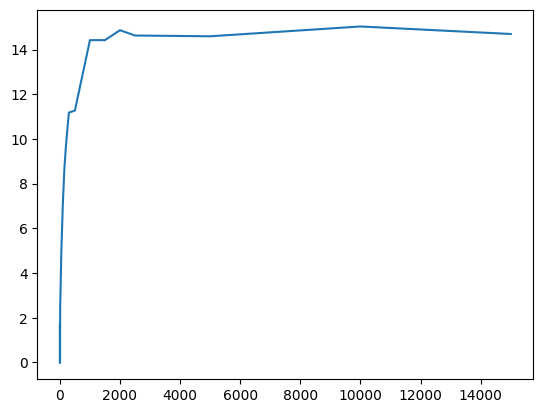

In [36]:
#In this next part I check how many swaps needed to move away from the original graph
n_swaps = [1,2,5,10,50,100,150,200,250,300,500,1000,1500,2000,2500,5000,10000,15000]
diffs = []
adj_orig = g.get_adjacency()
import numpy as np

for n_swap in n_swaps:
    rw_g = rewire_graph_unique_edges(data=data,n_swaps=n_swap)
    adj2 = rw_g.get_adjacency()
    diff = np.linalg.norm(adj_orig-adj2)
    diffs.append(diff)

plt.plot(n_swaps,diffs)


Creating the random graphs

In [40]:
num_randoms = 5000
adj1 = g_filtered.get_adjacency()
random_graphs_filtered = []
diffs_filtered = []
for i in range(num_randoms):
    print(i)
    random_graph_filtered = rewire_graph_unique_edges(data_cyt_filtered,1,n_swaps=3000)
    random_graphs_filtered.append(random_graph_filtered)
    adj2 = random_graph_filtered.get_adjacency()
    diff = np.linalg.norm(adj1-adj2)
    diffs_filtered.append(diff)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [39]:
num_randoms = 5000
adj1 = g.get_adjacency()
random_graphs_unfiltered = []
diffs_unfiltered = []
for i in range(num_randoms):
    print(i)
    random_graph_unfiltered = rewire_graph_unique_edges(data,1,n_swaps=3000)
    random_graphs_unfiltered.append(random_graph_unfiltered)
    adj2 = random_graph_unfiltered.get_adjacency()
    diff = np.linalg.norm(adj1-adj2)
    diffs_unfiltered.append(diff)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_74288/268958373.py:13: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):


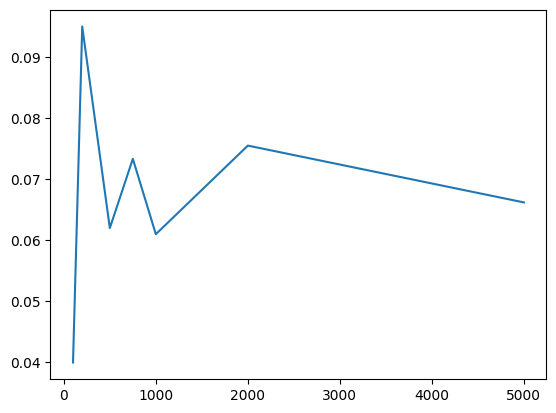

In [ ]:
thrsh = count_excitable_motif(g_filtered)
nums_random_for_p_value = [100,200,500,750,1000,2000,5000]
p_values = []
for num_random_for_p_value in nums_random_for_p_value:
    num_excitable_motifs = []
    random_graphs_filtered_to_check = np.random.choice(random_graphs_filtered,num_random_for_p_value)
    for random_graph in random_graphs_filtered_to_check:
        num_excitable_motifs.append(count_excitable_motif(random_graph))
    num_excitable_motifs = np.array(num_excitable_motifs)
    p_values.append((len(num_excitable_motifs[num_excitable_motifs>thrsh])/num_random_for_p_value))

plt.plot(nums_random_for_p_value,p_values)

/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_74288/268958373.py:13: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):


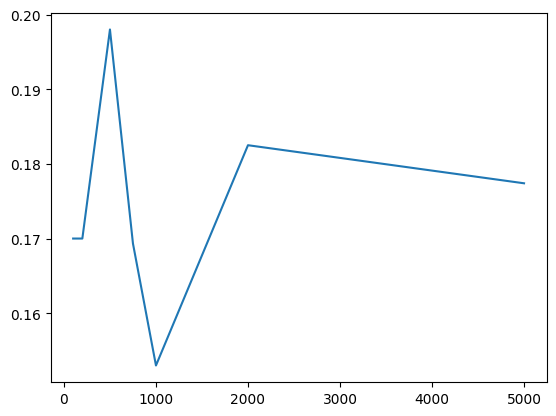

In [45]:
thrsh = count_excitable_motif(g)
nums_random_for_p_value = [100,200,500,750,1000,2000,5000]
p_values = []
for num_random_for_p_value in nums_random_for_p_value:
    num_excitable_motifs = []
    random_graphs_unfiltered_to_check = np.random.choice(random_graphs_unfiltered,num_random_for_p_value)
    for random_graph in random_graphs_unfiltered_to_check:
        num_excitable_motifs.append(count_excitable_motif(random_graph))
    num_excitable_motifs = np.array(num_excitable_motifs)
    p_values.append((len(num_excitable_motifs[num_excitable_motifs>thrsh])/num_random_for_p_value))

plt.plot(nums_random_for_p_value,p_values)


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_74288/268958373.py:13: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):


Average number of excitable motifs in graphs: 27.6766
Standard deviations of number of excitable motifs in graphs: 4.071659666524205
Signifcance of excitable motif (in units of standard deviation): 0.8162273549834872


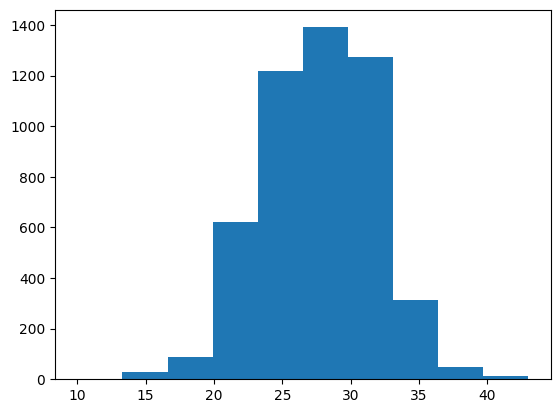

In [50]:
num_excitable_motifs = np.array([count_excitable_motif(random_graph) for random_graph in random_graphs_unfiltered])
plt.hist(num_excitable_motifs)
thrsh = count_excitable_motif(g)

print("Average number of excitable motifs in graphs:",num_excitable_motifs.mean())
print("Standard deviations of number of excitable motifs in graphs:",num_excitable_motifs.std())
print("Signifcance of excitable motif (in units of standard deviation):",abs(thrsh-num_excitable_motifs.mean())/num_excitable_motifs.std())

/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_74288/268958373.py:13: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):


Average number of excitable motifs in filtered graphs: 16.9206
Standard deviations of number of excitable motifs in filtered graphs: 3.0415613819221208
Signifcance of excitable motif (in units of standard deviation): 1.3412190279132274


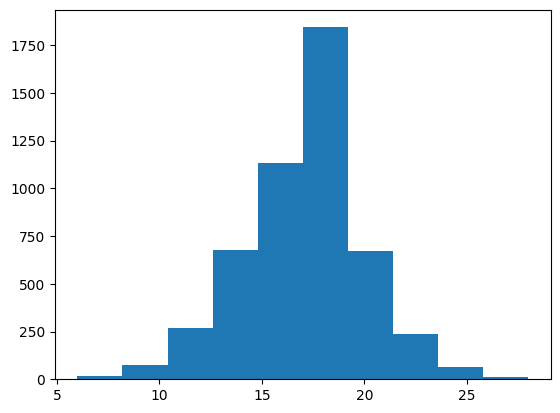

In [51]:
num_excitable_motifs = np.array([count_excitable_motif(random_graph) for random_graph in random_graphs_filtered])
plt.hist(num_excitable_motifs)
thrsh = count_excitable_motif(g_filtered)
print("Average number of excitable motifs in filtered graphs:",num_excitable_motifs.mean())
print("Standard deviations of number of excitable motifs in filtered graphs:",num_excitable_motifs.std())
print("Signifcance of excitable motif (in units of standard deviation):",abs(thrsh-num_excitable_motifs.mean())/num_excitable_motifs.std())

In [47]:
filtered_count,edges,dfs = find_excitable_motif(g_filtered)
print("Number of excitable motifs in the filtered graph (No TGFb and IFNg):",filtered_count)
print("Cell pairs of excitable motifs in the filtered graph (No TGFb and IFNg):",edges)


Number of excitable motifs in the filtered graph (No TGFb and IFNg): 21
Cell pairs of excitable motifs in the filtered graph (No TGFb and IFNg): [('T_CD4', 'B'), ('T_CD4', 'T_reg'), ('Monocyte', 'DC'), ('T_reg', 'B'), ('Eosinophil', 'B'), ('DC', 'B'), ('DC', 'Macrophage'), ('DC', 'Monocyte'), ('DC', 'Th1'), ('DC', 'Th2'), ('DC', 'Th17'), ('DC', 'Mast'), ('DC', 'T_reg'), ('Mast', 'B'), ('Macrophage', 'T_reg'), ('Macrophage', 'Mast'), ('Macrophage', 'Basophil'), ('Macrophage', 'B'), ('Macrophage', 'Th17'), ('Macrophage', 'Th1'), ('Macrophage', 'DC')]


/var/folders/rv/5ptfmp3s2vv4bd8tl_hpwgw00000gp/T/ipykernel_74288/268958373.py:41: DeprecationWarning: Graph.are_connected() is deprecated; use Graph.are_adjacent() instead
  if g.are_connected(a, a) and g.are_connected(a, b) and g.are_connected(b, a):


### Counting all motifs and and finding significance

In [52]:
def create_motif_from_str (motif_str):
    motif = ig.Graph(directed=True)
    motif.add_vertices(2)  # Two unique nodes: A, B
    for i,ch in enumerate(motif_str):
        if i==0 and ch!='0':
            motif.add_edge(0,0)
        if i==1 and ch!='0':
            motif.add_edge(0,1)
        if i==2 and ch!='0':
            motif.add_edge(1,1)
        if i==3 and ch!='0':
            motif.add_edge(1,0)
    return motif

def char_to_action (char):
    if char=='1': 
        return 'weight_positive'
    elif char=='2':
        return 'weight_negative'
    else: return ''


def count_motif_no_multiple_edges (g,motif_str):
    motif = create_motif_from_str(motif_str)
    # Step 4: Find motifs using LAD (supports self-loops)
    matches = g.get_subisomorphisms_lad(motif)
    filtered_count = 0
    for match in matches:
        add = 1
        a, b = g.vs[match[0]]["name"], g.vs[match[1]]["name"]
        for i,ch in enumerate(motif_str):
            if i==0 and ch!='0':
                edge_id = g.get_eid(a, a)
                add *= g.es[edge_id][char_to_action(ch)]
            if i==1 and ch!='0':
                edge_id = g.get_eid(a, b)
                add *= g.es[edge_id][char_to_action(ch)]
            if i==2 and ch!='0':
                edge_id = g.get_eid(b, b)
                add *= g.es[edge_id][char_to_action(ch)]
            if i==3 and ch!='0':
                edge_id = g.get_eid(b, a)
                add *= g.es[edge_id][char_to_action(ch)]
        filtered_count+=add
    return filtered_count

def count_random_graphs_motif (data,motif_str, num_randoms,p = 0.999):
    num_motifs = np.zeros(shape = num_randoms)
    for i in range(num_randoms):
        random_graph = rewire_graph_unique_edges(data,p)
        count = count_motif_no_multiple_edges(random_graph,motif_str)
        num_motifs[i] = count
    return num_motifs


In [54]:
motif_strs = []
for i1 in range(3):
    for i2 in range(3):
        for i3 in range(3):
            for i4 in range(3):
                if i2==0 and i4==0:
                    continue
                motif_str = str(i1)+str(i2)+str(i3)+str(i4)
                motif_str_reversed = str(i3)+str(i4)+str(i1)+str(i2)
                if motif_str_reversed not in motif_strs:
                    motif_strs.append(motif_str)
print("total motifs:",len(motif_strs))
motifs_count_in_original_graph = []
motif_average_in_rewired_graphs = []
motif_std_in_rewired_graphs = []
p_value_in_rewired_graphs = []
motif_counts_in_rewired_graphs = []

for motif_str in motif_strs:
    print("motif str:",motif_str)
    thrsh = count_motif_no_multiple_edges(g,motif_str)
    motifs_count_in_original_graph.append(thrsh)
    print("motif count in original graph:",thrsh)
    num_motifs = np.array([count_motif_no_multiple_edges(r_g,motif_str) for r_g in random_graphs_unfiltered])
    motif_average_in_rewired_graphs.append(np.array(num_motifs).mean())
    motif_std_in_rewired_graphs.append(np.array(num_motifs).std())
    print("mean motif count in rewired graphs:",np.array(num_motifs).mean())
    print("motif sd in rewired graphs:",np.array(num_motifs).std())
    print("p value: ",len(num_motifs[num_motifs>thrsh])/len(num_motifs))
    p_value_in_rewired_graphs.append(len(num_motifs[num_motifs>thrsh])/len(num_motifs))
    motif_counts_in_rewired_graphs.append(num_motifs)

total motifs: 39
motif str: 0001
motif count in original graph: 274
mean motif count in rewired graphs: 281.9956
motif sd in rewired graphs: 1.9269615045454331
p value:  1.0
motif str: 0002
motif count in original graph: 74
mean motif count in rewired graphs: 75.2222
motif sd in rewired graphs: 1.3467097534361292
p value:  0.7074
motif str: 0011
motif count in original graph: 196
mean motif count in rewired graphs: 127.8656
motif sd in rewired graphs: 20.08721824046326
p value:  0.0
motif str: 0012
motif count in original graph: 51
mean motif count in rewired graphs: 37.9842
motif sd in rewired graphs: 7.476867683729598
p value:  0.0306
motif str: 0021
motif count in original graph: 81
mean motif count in rewired graphs: 57.3188
motif sd in rewired graphs: 19.531747657595826
p value:  0.1216
motif str: 0022
motif count in original graph: 27
mean motif count in rewired graphs: 17.912
motif sd in rewired graphs: 6.520265025288466
p value:  0.063
motif str: 0101
motif count in original gr

In [ ]:
motifs_df = pd.DataFrame({'motif':motif_strs,'count in original graph':motifs_count_in_original_graph,'mean count in rewired graphs':motif_average_in_rewired_graphs,
                          'sd count in rewired graphs':motif_std_in_rewired_graphs,'p value':p_value_in_rewired_graphs,'counts in rewired graphs':motif_counts_in_rewired_graphs})
motifs_df = motifs_df.sort_values(by = 'p value')
motifs_df

,motif,count in original graph,mean count in rewired graphs,sd count in rewired graphs,p value,counts in rewired graphs
8,0110,169,115.994,19.293573,0.000,"[146, 108, 120, 100, 137, 134, 88, 94, 118, 12..."
15,0210,45,28.362,4.948834,0.000,"[29, 30, 28, 24, 30, 33, 25, 22, 30, 31, 21, 2..."
22,1012,32,14.584,5.095777,0.000,"[22, 9, 14, 9, 14, 16, 9, 12, 13, 14, 8, 13, 1..."
21,1011,113,47.668,17.530481,0.000,"[95, 36, 50, 31, 57, 58, 22, 33, 45, 52, 34, 5..."
9,0111,90,59.972,8.755982,0.000,"[66, 57, 60, 54, 61, 70, 55, 55, 64, 62, 52, 6..."
25,1111,72,32.088,11.080445,0.000,"[50, 26, 32, 24, 34, 44, 18, 26, 36, 36, 22, 3..."
24,1022,18,6.352,2.992674,0.000,"[4, 7, 8, 5, 10, 11, 9, 5, 4, 6, 2, 7, 3, 2, 0..."
2,0011,166,108.918,18.389978,0.002,"[161, 92, 116, 97, 116, 115, 83, 102, 106, 120..."
23,1021,38,16.140,7.583166,0.002,"[23, 18, 19, 11, 29, 31, 17, 10, 5, 18, 12, 20..."
33,1222,6,2.026,1.552200,0.004,"[3, 2, 1, 2, 4, 2, 5, 3, 0, 3, 2, 0, 0, 0, 0, ..."


(<Figure size 1600x4000 with 79 Axes>,
 array([[<AxesSubplot: title={'center': '0110\n p value: 0.0'}>,
         <AxesSubplot: title={'center': '0210\n p value: 0.0'}>,
         <AxesSubplot: title={'center': '1012\n p value: 0.0'}>,
         <AxesSubplot: title={'center': '1011\n p value: 0.0'}>],
        [<AxesSubplot: title={'center': '0111\n p value: 0.0'}>,
         <AxesSubplot: title={'center': '1111\n p value: 0.0'}>,
         <AxesSubplot: title={'center': '1022\n p value: 0.0'}>,
         <AxesSubplot: title={'center': '0011\n p value: 0.002'}>],
        [<AxesSubplot: title={'center': '1021\n p value: 0.002'}>,
         <AxesSubplot: title={'center': '1121\n p value: 0.004'}>,
         <AxesSubplot: title={'center': '1222\n p value: 0.004'}>,
         <AxesSubplot: title={'center': '1221\n p value: 0.006'}>],
        [<AxesSubplot: title={'center': '1120\n p value: 0.008'}>,
         <AxesSubplot: title={'center': '0221\n p value: 0.012'}>,
         <AxesSubplot: title={'cen

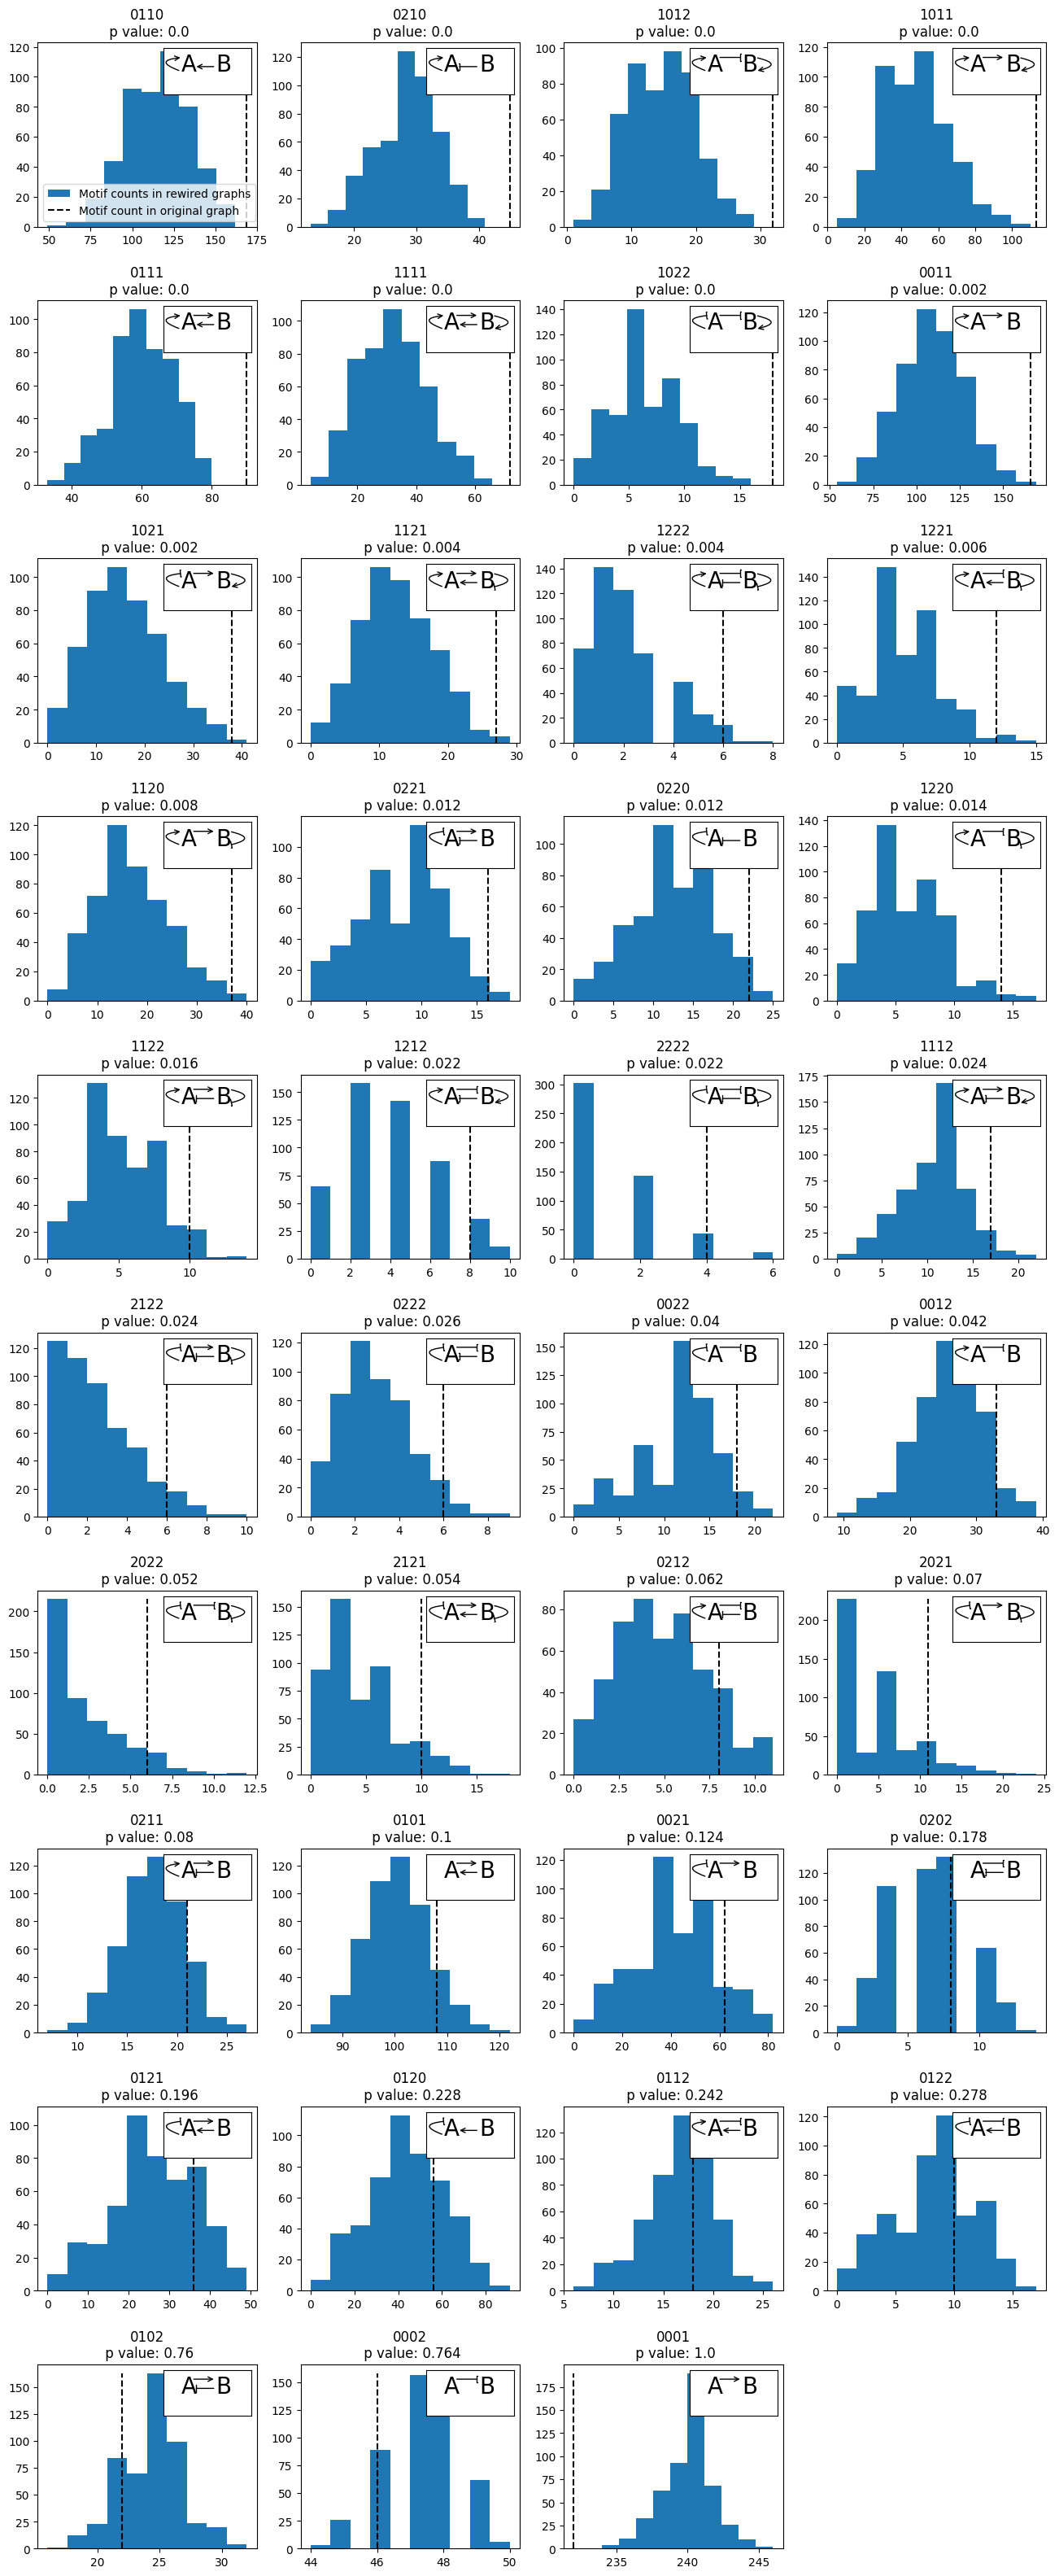

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches

def draw_arrow (ax,start,end,effect,type='str',linestyle = '-',d = 0.2):
    arrowstyle = '->' if effect == "1" else '-['  # solid for positive, dashed for negative
    if type=='str':
        connecstyle = 'arc3'
    elif type=='circ':
        connecstyle = f'arc3, rad={.5*0.15/d}'
    elif type=='circ_ccw':
        connecstyle = f'arc3, rad={-.5*0.15/d}'
    elif type=='full_circ':
        connecstyle = f'arc3, rad={3*0.15/d}'
    elif type=='full_circ_ccw':
        connecstyle = f'arc3, rad={-3*0.15/d}'
    kw = dict(arrowstyle=arrowstyle, color="k",linestyle=linestyle,)
    mutation_scale = 10 if effect =='1' else 3
    a3 = patches.FancyArrowPatch(start, end, mutation_scale=mutation_scale,
                            connectionstyle=connecstyle, **kw,zorder = 0)
    ax.add_patch(a3)

def plot_circuit(ax,motif_str):
    axins = inset_axes(ax, width='40%', height='25%')
    axins.set_xlim(-1,4)
    axins.set_ylim(0.25,0.75)
    a_loc_x = 0
    a_loc_y = 0.5
    b_loc_x = 2
    b_loc_y = 0.5
    axins.text(a_loc_x,a_loc_y,'A',fontsize = 20)
    axins.text(b_loc_x,b_loc_y,'B',fontsize = 20)
    d = 0.5
    for i,ch in enumerate(motif_str):
        if i==0 and ch!='0':
            draw_arrow(axins,(0,0.5),(0.1,0.65),ch,'full_circ_ccw',d = 0.2)
        if i==1 and ch!='0':
            draw_arrow(axins,(0.6,0.65),(2,0.65),effect = ch,d = d)
        if i==3 and ch!='0':
            draw_arrow(axins,(2,0.55),(0.75,0.55),effect = ch,d = d)
        if i==2 and ch!='0':
            draw_arrow(axins,(2.75,0.65),(2.75,0.5),ch,'full_circ_ccw',d = 0.2)
    axins.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
from math import ceil
motifs_df = motifs_df.sort_values(by = 'p value',ascending=True)
def plot_hists_and_circuits (df,ncols = 4,legend_on_which_ax = 0,legend_bbox = None,show_p_value = False, legend_loc = 'lower left',
                             show_motif_num = False):
    nrows = ceil(len(df)/ncols)
    fig,axs = plt.subplots(nrows = nrows, ncols = ncols, figsize = (4*ncols,4*nrows))
    for i in range(len(df)):
        if nrows == 1:
            ax = axs[i%ncols]
        else:
            ax = axs[int(i/ncols),i%ncols]
        motif_str = df.iloc[i]['motif']
        ttl = ''
        if show_motif_num:
            ttl += motif_str
            if show_p_value:
                ttl += f"\n p value: {df.iloc[i]['p value']}"
        else:
            if show_p_value:
                ttl += f"p value: {df.iloc[i]['p value']}"
        ax.set_title(ttl)
        n,_,_ = ax.hist(df.iloc[i]['counts in rewired graphs'],label = 'Motif counts in rewired graphs')
        ax.plot([df.iloc[i]['count in original graph']]*100, np.linspace(0,max(n),100),'--',color = 'black',label = 'Motif count in original graph')
        if i==legend_on_which_ax:
            if legend_bbox==None:
                ax.legend(loc = legend_loc)
            else:
                ax.legend(loc = legend_loc, bbox_to_anchor = legend_bbox)

        if motif_str[1]=='0' or (motif_str[0]=='0' and motif_str[2]!='0'):
            motif_str = motif_str[2]+motif_str[3]+motif_str[0]+motif_str[1]
        plot_circuit(ax,motif_str)
    for i in range(len(df),len(axs.flatten())):
        if nrows == 1:
            ax = axs[i%ncols]
        else:
            ax = axs[int(i/ncols),i%ncols]
        ax.set_axis_off()
    if np.sum([show_p_value,show_motif_num])==2:
        plt.subplots_adjust(hspace=0.4)
    return fig, axs
plot_hists_and_circuits(motifs_df,show_p_value=True,show_motif_num=True)

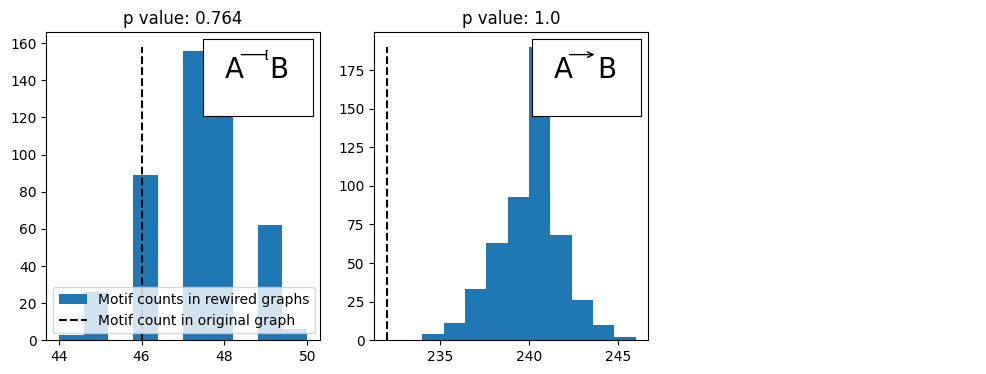

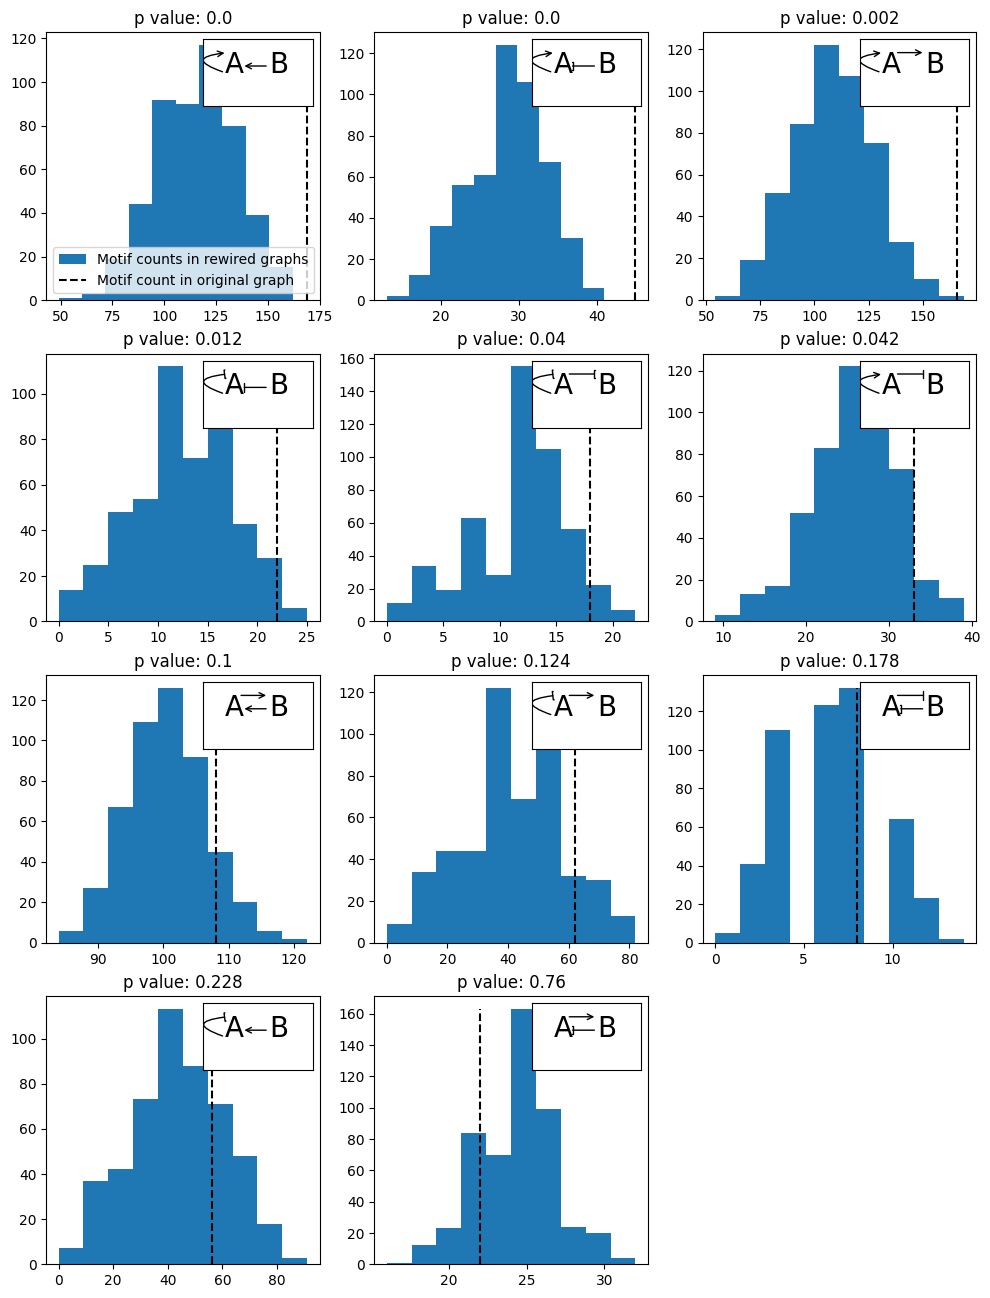

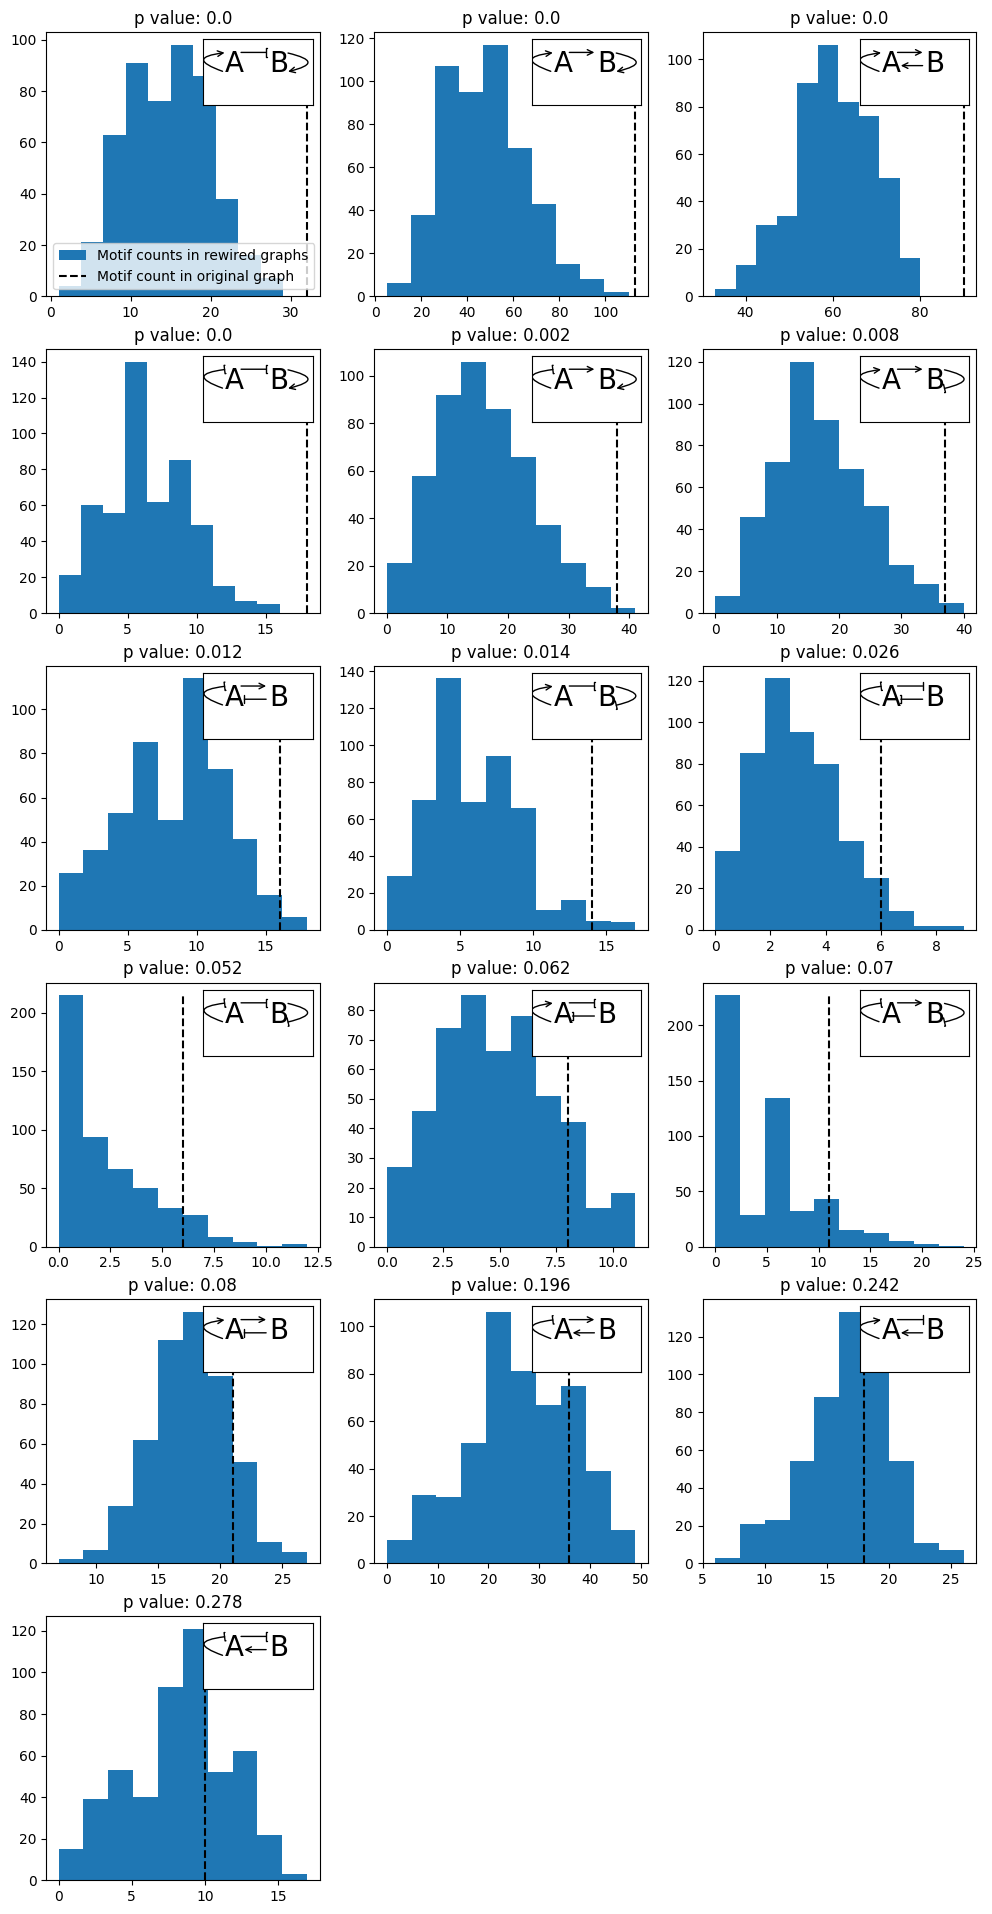

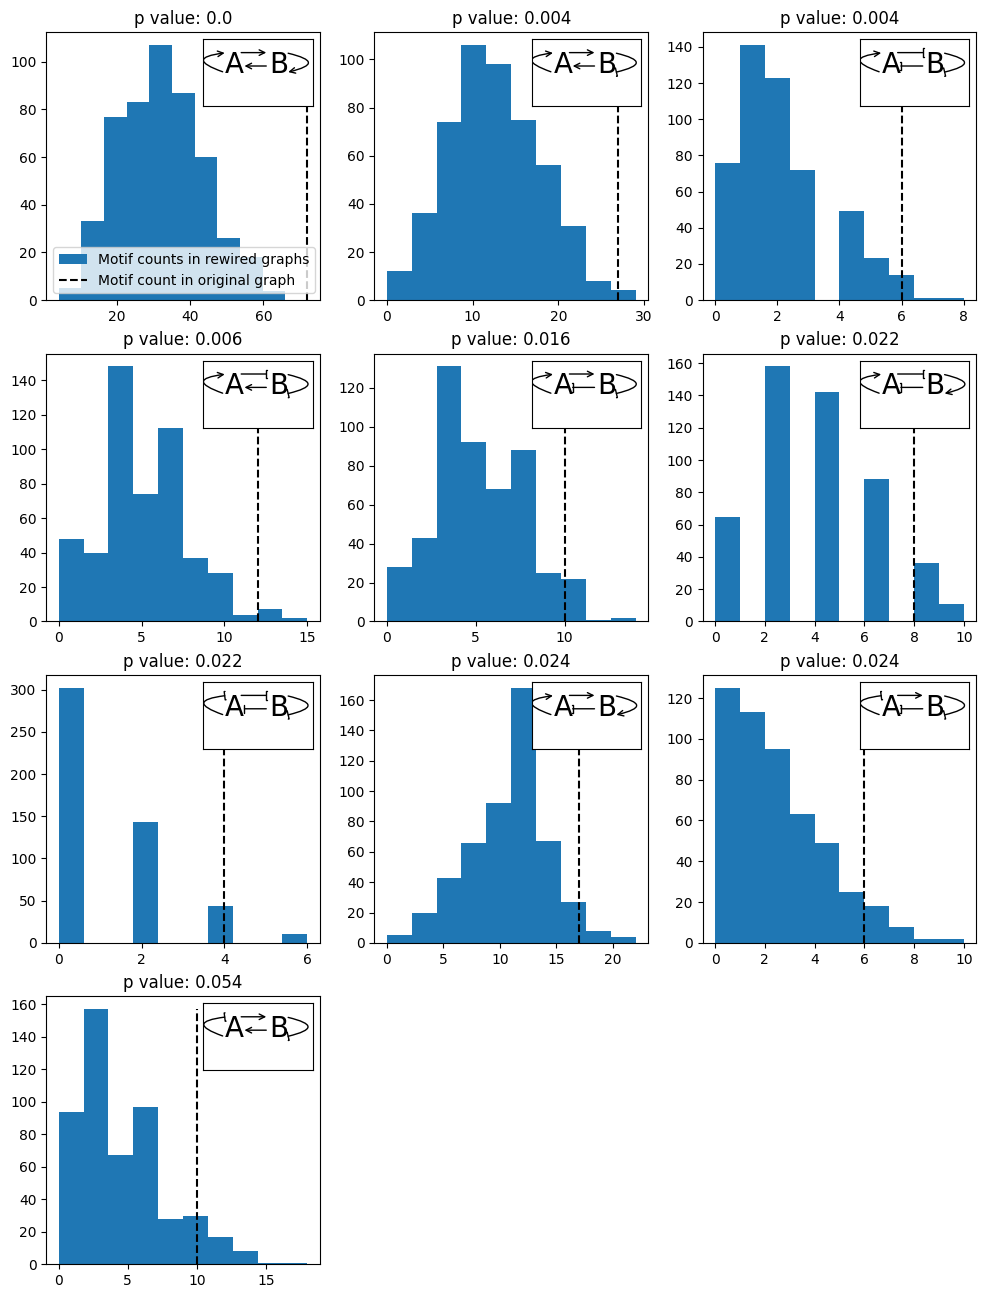

In [ ]:
motifs_df1 = motifs_df[[motif.count('0')==3 for motif in motifs_df['motif']]]
fig1,axs1 = plot_hists_and_circuits(motifs_df1,ncols = 3,show_p_value=True)

motifs_df2 = motifs_df[[motif.count('0')==2 for motif in motifs_df['motif']]]
fig2,axs2 = plot_hists_and_circuits(motifs_df2,ncols = 3,show_p_value=True)

motifs_df3 = motifs_df[[motif.count('0')==1 for motif in motifs_df['motif']]]
fig3,axs3 = plot_hists_and_circuits(motifs_df3,ncols = 3,show_p_value=True)

motifs_df4 = motifs_df[[motif.count('0')==0 for motif in motifs_df['motif']]]
fig4,axs4 = plot_hists_and_circuits(motifs_df4,ncols = 3,show_p_value=True)


Text(0.5, 0.98, 'Motifs in Flattened network\n\n')

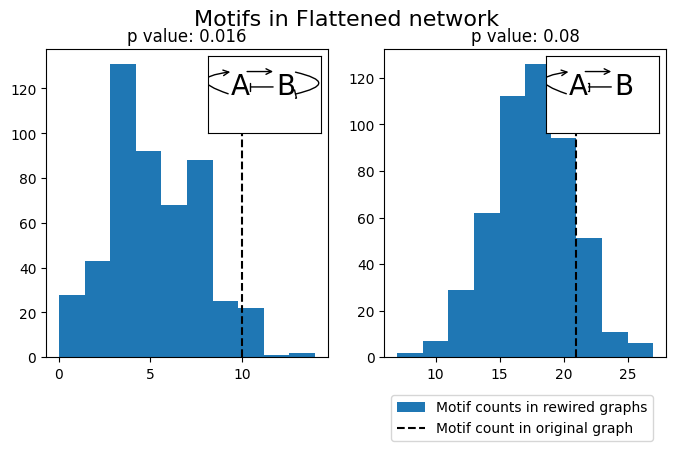

In [ ]:
excitable_motifs_to_plot = ['0211','1122']
mask_excitable = [motif in excitable_motifs_to_plot for motif in motifs_df['motif']]
excitable_motifs_to_plot_df = motifs_df[mask_excitable]
excitable_motifs_to_plot_df = excitable_motifs_to_plot_df.sort_values(by = 'p value')
fig, axs = plot_hists_and_circuits(excitable_motifs_to_plot_df,2,1, (0,-0.1),True,'upper left')
fig.suptitle('Motifs in Flattened network\n\n',fontsize = 16)